In [3]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise: Seoul Bike Sharing (LASSO)

## Context

<center>
<img src="assets/bike_sharing.jpg" width=60%/>    
</center>

Let's revisit the Seoul Bike Sharing Problem


* We will start from our approach with categorical input
* ...We we will apply a LASSO approach to identify the most relevant attributes

In [4]:
import pandas as pd
import os

fname = os.path.join('data', 'SeoulBikeData.csv')
data = pd.read_csv(fname, sep=',')

num_input = ['Temperature(^C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(^C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
cat_input = ['Hour', 'Seasons', 'Holiday', 'Functioning Day']
output = 'Rented Bike Count'

data_d = pd.get_dummies(data[num_input + cat_input + [output]], columns=cat_input)
data_d.head()

,Temperature(^C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(^C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Rented Bike Count,Hour_0,...,Hour_22,Hour_23,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,254,1,...,0,0,0,0,0,1,0,1,0,1
1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,204,0,...,0,0,0,0,0,1,0,1,0,1
2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,173,0,...,0,0,0,0,0,1,0,1,0,1
3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,107,0,...,0,0,0,0,0,1,0,1,0,1
4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,78,0,...,0,0,0,0,0,1,0,1,0,1


## Train/Test Split and Standardization

First, we perform input/output and train/test split as usual

In [5]:
from sklearn.model_selection import train_test_split

all_input = [c for c in data_d if c != output] # we cannot use `cat_input`, since the names have changed
X = data_d[all_input]
y = data_d[[output]] # We use a list, so we obtain a DataFrame

test_set_fraction = .34
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=test_set_fraction, random_state=42)

print(f"Number of training examples: {len(X_tr)}")
print(f"Number of test examples: {len(X_ts)}")

Number of training examples: 5781
Number of test examples: 2979


...But then we also apply a standardization step:

In [6]:
from sklearn.preprocessing import StandardScaler

input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_tr_s = input_scaler.fit_transform(X_tr)
y_tr_s = output_scaler.fit_transform(y_tr)

X_ts_s = input_scaler.fit_transform(X_ts)
y_ts_s = output_scaler.fit_transform(y_ts)

print(f"X_tr_s: {X_tr_s}")
print(f"y_tr_s: {y_tr_s}")

X_tr_s: [[ 0.941345   -1.0856807   2.18719026 ...  0.2268772  -0.18782803
   0.18782803]
 [ 0.6052002   0.18691014  0.06051515 ...  0.2268772  -0.18782803
   0.18782803]
 [-0.88224056  0.82320556 -0.22948601 ...  0.2268772  -0.18782803
   0.18782803]
 ...
 [ 1.38673686  0.18691014  0.9305186  ...  0.2268772  -0.18782803
   0.18782803]
 [-1.37805414 -0.35149368 -0.61615421 ...  0.2268772  -0.18782803
   0.18782803]
 [ 0.52956762 -0.15571047 -1.19615651 ...  0.2268772  -0.18782803
   0.18782803]]
y_tr_s: [[ 1.58078069]
 [ 0.36153697]
 [-0.65810974]
 ...
 [ 0.44973099]
 [-0.59776646]
 [ 1.22645732]]


## Building a LASSO Model

Now, based on the code from the previous lecture, try to:

* Build a LASSO model (start with $\alpha = 0.1$) 
* Train it on `X_tr_s`, `y_tr_s`
* Display the value of the $R^2$ coefficient for both the training and the test set
* Plot the values of the coefficients (the code for doing this is included and it assumes the model is in a variables called `m`)

In [7]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

m = Lasso(alpha=0.01)
m.fit(X_tr_s, y_tr_s);
y_pred_tr_s, y_pred_ts_s = m.predict(X_tr_s), m.predict(X_ts_s)
print(f'R2: {r2_score(y_tr_s, y_pred_tr_s):.3} (training), {r2_score(y_ts_s, y_pred_ts_s):.3} (test)')

R2: 0.66 (training), 0.65 (test)


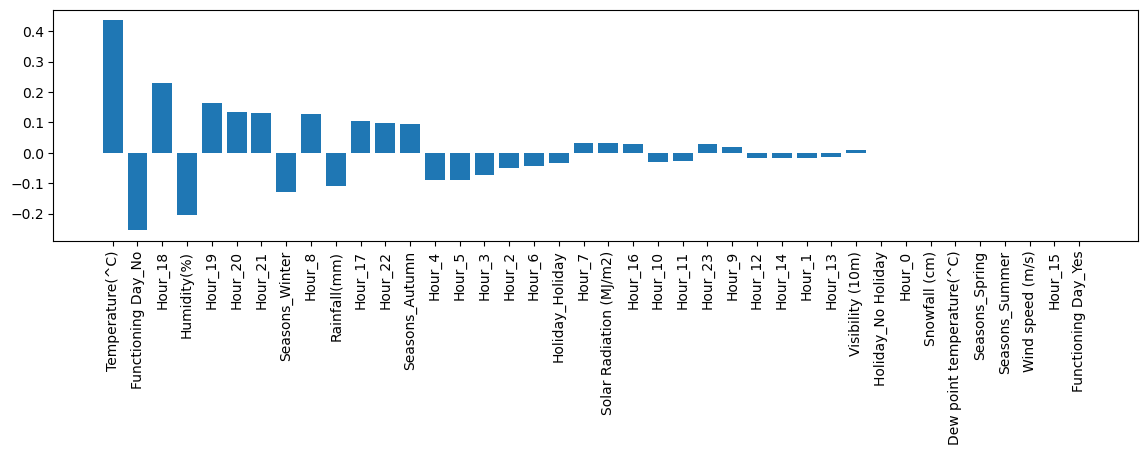

In [8]:
import numpy as np
from matplotlib import pyplot as plt


idx = np.argsort(-np.abs(m.coef_))
scores = m.coef_[idx]
plt.figure(figsize=(14, 3))
plt.bar(0.5 + np.arange(len(idx)), scores, tick_label=X.columns[idx]);
plt.xticks(rotation=90);

Some open questions:

* What happens if you change the value of $\alpha$?
* Try calibrating $\alpha$ until the $R^2$ is similar to the one from the previous exercise, but unimportant attributes have been filtered out